### SOLID: a Framework of Synergizing Optimization and Large Language Models for Intelligent Decision-Making
Authors: Yinsheng Wang, Tario You, Léonard Boussioux

In this model, we build two agents to decide an investment strategy for a portfolio of stocks.
For simplicity, we assume that the portfolio consists of 4 stocks: NVDA, GOOG, MSTR, and SMCI.
The first agent is a mean-variance optimization model. It aims to minimize the portfolio variance while achieving a target return.
The second agent is a GPT-based Language Model. Through prompt-based learning, it aims to generate a portfolio strategy that maximizes the portfolio return.
The two agents will communicate with each other to reach a consensus on the portfolio strategy, i.e., the portfolio weights for the two stocks.

#### Import necessary libraries

In [134]:
from openai import OpenAI
import sys
import json
import pandas as pd
from tqdm import tqdm
import yfinance as yf
import calendar
import holidays
import pandas_market_calendars as mcal
import datetime
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import risk_models
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List
from openai import OpenAI
import os
import re
import random
import pandas as pd
from tqdm import tqdm
import pypfopt
import yfinance as yf
from gurobipy import Model, GRB, quicksum
import warnings
from dotenv import load_dotenv

load_dotenv()

warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False)  # Prevent splitting
pd.set_option('display.max_columns', None)        # Show all columns
pd.set_option('display.max_rows', None)           # Optional: Show all rows

api_key = os.getenv("PPLX")

# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "WMT"]
tickers = ["AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"]

#### Functions to save data locally

In [90]:
def save_data(data, file_path='assets/stock_data.json'):
    """
    Saves the dictionary 'data' to a JSON file at 'file_path'.
    """
    with open(file_path, 'w') as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {file_path}")

def load_data(file_path='assets/stock_data.json'):
    """
    Loads JSON data from 'file_path' and returns it as a dictionary.
    """
    with open(file_path, 'r') as fp:
        data = json.load(fp)
    print(f"Data loaded from {file_path}")
    return data

def patch_data(
    tickers,
    file_path='assets/stock_data.json'
):
    """
    Load existing data from file_path, then patch each month's dictionary
    to include 'MSTR' and 'SMCI' using Perplexity.ai's OpenAI-like client calls.
    Finally, save the patched data back to file_path.
    """

    # 1) Load the existing data
    data = load_data(file_path)

    # 2) Set up your client, months, system prompt, etc.
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")

    months = [
        "January", "Febuary", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    
    system_prompt = {
        "role": "system",
        "content": (
            "Show me key news on [Company X] from [Date Range]. This list isn't exhaustive—earnings, leadership changes, regulatory updates, major headlines, M&A, industry trends, product launches, analyst opinions, investor activism, competitor moves—but only pick what's most representative for [Company X]'s stock performance. If other items seem more important, include them. Summarize in bullet points; avoid complete sentences; aim for maximum information. You don't have to include everything, just the key pieces. Keep final summary around 400 words."
        )
    }

    # 3) Patch each month's dictionary if tickers dont exist
    for i, monthly_data in enumerate(data):
        for j in tqdm(range(len(tickers))):
            ticker = tickers[j]
            if ticker not in monthly_data:
                # Build the request messages for the missing ticker
                messages = [
                    system_prompt,
                    {
                        "role": "user",
                        "content": f"What happened to {ticker} in {months[i]} 2024?"
                    }
                ]

                # Make the API call
                response = client.chat.completions.create(
                    model="llama-3.1-sonar-large-128k-online",
                    messages=messages,
                )

                # Save the result in the monthly dictionary
                monthly_data[ticker] = {"news": response.choices[0].message.content}
                print(f'patched: month {months[i]}\t{ticker}')
            else:
                print(f'skipping: {ticker}')
            
            save_data(data, file_path)

    # 4) Save the patched data back to the JSON file
    save_data(data, file_path)

#### Using Perplexity to gather news about the tickers

In [135]:
client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
months = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
data = [
    # Jan
    # {
    #     "MSFT":{
    #         "news": "yay", # news for all of Jan
    #         "price": 20 # last day's closing price - Jan 31
    #     }
    # }
]

patch_data(tickers)

# save_data(data)

Data loaded from assets/stock_data.json


 11%|█         | 1/9 [00:09<01:14,  9.35s/it]

patched: month January	AAPL
Data saved to assets/stock_data.json


 22%|██▏       | 2/9 [00:15<00:54,  7.75s/it]

patched: month January	JPM
Data saved to assets/stock_data.json


 33%|███▎      | 3/9 [00:23<00:46,  7.71s/it]

patched: month January	XOM
Data saved to assets/stock_data.json


 44%|████▍     | 4/9 [00:31<00:38,  7.66s/it]

patched: month January	JNJ
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json


 67%|██████▋   | 6/9 [00:38<00:16,  5.61s/it]

patched: month January	HD
Data saved to assets/stock_data.json


 78%|███████▊  | 7/9 [00:48<00:13,  6.68s/it]

patched: month January	AMT
Data saved to assets/stock_data.json


 89%|████████▉ | 8/9 [00:56<00:07,  7.06s/it]

patched: month January	BA
Data saved to assets/stock_data.json


100%|██████████| 9/9 [01:06<00:00,  7.34s/it]


patched: month January	NEE
Data saved to assets/stock_data.json


 11%|█         | 1/9 [00:09<01:12,  9.01s/it]

patched: month Febuary	AAPL
Data saved to assets/stock_data.json


 22%|██▏       | 2/9 [00:15<00:50,  7.24s/it]

patched: month Febuary	JPM
Data saved to assets/stock_data.json


 33%|███▎      | 3/9 [00:22<00:43,  7.18s/it]

patched: month Febuary	XOM
Data saved to assets/stock_data.json


 44%|████▍     | 4/9 [00:28<00:33,  6.76s/it]

patched: month Febuary	JNJ
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json


 67%|██████▋   | 6/9 [00:33<00:13,  4.58s/it]

patched: month Febuary	HD
Data saved to assets/stock_data.json


 78%|███████▊  | 7/9 [00:38<00:09,  4.74s/it]

patched: month Febuary	AMT
Data saved to assets/stock_data.json


 89%|████████▉ | 8/9 [00:43<00:04,  4.71s/it]

patched: month Febuary	BA
Data saved to assets/stock_data.json


100%|██████████| 9/9 [00:50<00:00,  5.61s/it]


patched: month Febuary	NEE
Data saved to assets/stock_data.json


 11%|█         | 1/9 [00:11<01:35, 11.88s/it]

patched: month March	AAPL
Data saved to assets/stock_data.json


 22%|██▏       | 2/9 [00:20<01:07,  9.68s/it]

patched: month March	JPM
Data saved to assets/stock_data.json


 33%|███▎      | 3/9 [00:28<00:54,  9.06s/it]

patched: month March	XOM
Data saved to assets/stock_data.json


 44%|████▍     | 4/9 [00:35<00:42,  8.44s/it]

patched: month March	JNJ
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json


 67%|██████▋   | 6/9 [00:44<00:18,  6.19s/it]

patched: month March	HD
Data saved to assets/stock_data.json


 78%|███████▊  | 7/9 [00:52<00:13,  6.83s/it]

patched: month March	AMT
Data saved to assets/stock_data.json


 89%|████████▉ | 8/9 [01:01<00:07,  7.27s/it]

patched: month March	BA
Data saved to assets/stock_data.json


100%|██████████| 9/9 [01:09<00:00,  7.68s/it]


patched: month March	NEE
Data saved to assets/stock_data.json


 11%|█         | 1/9 [00:09<01:12,  9.09s/it]

patched: month April	AAPL
Data saved to assets/stock_data.json


 22%|██▏       | 2/9 [00:19<01:08,  9.82s/it]

patched: month April	JPM
Data saved to assets/stock_data.json


 33%|███▎      | 3/9 [00:27<00:52,  8.82s/it]

patched: month April	XOM
Data saved to assets/stock_data.json


 44%|████▍     | 4/9 [00:36<00:45,  9.04s/it]

patched: month April	JNJ
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json


 67%|██████▋   | 6/9 [00:42<00:17,  5.79s/it]

patched: month April	HD
Data saved to assets/stock_data.json


 78%|███████▊  | 7/9 [00:52<00:13,  6.88s/it]

patched: month April	AMT
Data saved to assets/stock_data.json


 89%|████████▉ | 8/9 [00:57<00:06,  6.56s/it]

patched: month April	BA
Data saved to assets/stock_data.json


100%|██████████| 9/9 [01:05<00:00,  7.32s/it]


patched: month April	NEE
Data saved to assets/stock_data.json


 11%|█         | 1/9 [00:09<01:15,  9.41s/it]

patched: month May	AAPL
Data saved to assets/stock_data.json


 22%|██▏       | 2/9 [00:16<00:54,  7.80s/it]

patched: month May	JPM
Data saved to assets/stock_data.json


 33%|███▎      | 3/9 [00:25<00:51,  8.63s/it]

patched: month May	XOM
Data saved to assets/stock_data.json


 44%|████▍     | 4/9 [00:30<00:35,  7.01s/it]

patched: month May	JNJ
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json


 67%|██████▋   | 6/9 [00:37<00:15,  5.13s/it]

patched: month May	HD
Data saved to assets/stock_data.json


 78%|███████▊  | 7/9 [00:46<00:12,  6.34s/it]

patched: month May	AMT
Data saved to assets/stock_data.json


 89%|████████▉ | 8/9 [01:00<00:08,  8.39s/it]

patched: month May	BA
Data saved to assets/stock_data.json


100%|██████████| 9/9 [01:07<00:00,  7.49s/it]


patched: month May	NEE
Data saved to assets/stock_data.json


 11%|█         | 1/9 [00:11<01:34, 11.81s/it]

patched: month June	AAPL
Data saved to assets/stock_data.json


 22%|██▏       | 2/9 [00:22<01:17, 11.05s/it]

patched: month June	JPM
Data saved to assets/stock_data.json


 33%|███▎      | 3/9 [00:30<00:57,  9.60s/it]

patched: month June	XOM
Data saved to assets/stock_data.json


 44%|████▍     | 4/9 [00:39<00:48,  9.61s/it]

patched: month June	JNJ
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json


 67%|██████▋   | 6/9 [00:46<00:18,  6.24s/it]

patched: month June	HD
Data saved to assets/stock_data.json


 78%|███████▊  | 7/9 [00:54<00:13,  6.71s/it]

patched: month June	AMT
Data saved to assets/stock_data.json


 89%|████████▉ | 8/9 [01:01<00:06,  6.93s/it]

patched: month June	BA
Data saved to assets/stock_data.json


100%|██████████| 9/9 [01:14<00:00,  8.30s/it]


patched: month June	NEE
Data saved to assets/stock_data.json


 11%|█         | 1/9 [00:08<01:04,  8.04s/it]

patched: month July	AAPL
Data saved to assets/stock_data.json


 22%|██▏       | 2/9 [00:18<01:04,  9.27s/it]

patched: month July	JPM
Data saved to assets/stock_data.json


 33%|███▎      | 3/9 [00:27<00:55,  9.30s/it]

patched: month July	XOM
Data saved to assets/stock_data.json


 44%|████▍     | 4/9 [00:37<00:48,  9.64s/it]

patched: month July	JNJ
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json


 67%|██████▋   | 6/9 [00:49<00:22,  7.56s/it]

patched: month July	HD
Data saved to assets/stock_data.json


 78%|███████▊  | 7/9 [01:01<00:17,  8.82s/it]

patched: month July	AMT
Data saved to assets/stock_data.json


 89%|████████▉ | 8/9 [01:06<00:07,  7.85s/it]

patched: month July	BA
Data saved to assets/stock_data.json


100%|██████████| 9/9 [01:19<00:00,  8.82s/it]


patched: month July	NEE
Data saved to assets/stock_data.json


 11%|█         | 1/9 [00:09<01:14,  9.37s/it]

patched: month August	AAPL
Data saved to assets/stock_data.json


 22%|██▏       | 2/9 [00:17<00:59,  8.51s/it]

patched: month August	JPM
Data saved to assets/stock_data.json


 33%|███▎      | 3/9 [00:24<00:47,  7.91s/it]

patched: month August	XOM
Data saved to assets/stock_data.json


 44%|████▍     | 4/9 [00:36<00:47,  9.54s/it]

patched: month August	JNJ
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json


 67%|██████▋   | 6/9 [00:41<00:17,  5.73s/it]

patched: month August	HD
Data saved to assets/stock_data.json


 78%|███████▊  | 7/9 [00:50<00:13,  6.77s/it]

patched: month August	AMT
Data saved to assets/stock_data.json


 89%|████████▉ | 8/9 [01:01<00:07,  7.92s/it]

patched: month August	BA
Data saved to assets/stock_data.json


100%|██████████| 9/9 [01:08<00:00,  7.61s/it]


patched: month August	NEE
Data saved to assets/stock_data.json


 11%|█         | 1/9 [00:12<01:37, 12.25s/it]

patched: month September	AAPL
Data saved to assets/stock_data.json


 22%|██▏       | 2/9 [00:20<01:08,  9.85s/it]

patched: month September	JPM
Data saved to assets/stock_data.json


 33%|███▎      | 3/9 [00:30<01:00, 10.08s/it]

patched: month September	XOM
Data saved to assets/stock_data.json


 44%|████▍     | 4/9 [00:39<00:48,  9.73s/it]

patched: month September	JNJ
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json


 67%|██████▋   | 6/9 [00:46<00:18,  6.32s/it]

patched: month September	HD
Data saved to assets/stock_data.json


 78%|███████▊  | 7/9 [01:00<00:16,  8.46s/it]

patched: month September	AMT
Data saved to assets/stock_data.json


 89%|████████▉ | 8/9 [01:12<00:09,  9.37s/it]

patched: month September	BA
Data saved to assets/stock_data.json


100%|██████████| 9/9 [01:21<00:00,  9.06s/it]


patched: month September	NEE
Data saved to assets/stock_data.json


 11%|█         | 1/9 [00:11<01:35, 11.91s/it]

patched: month October	AAPL
Data saved to assets/stock_data.json


 22%|██▏       | 2/9 [00:20<01:10, 10.12s/it]

patched: month October	JPM
Data saved to assets/stock_data.json


 33%|███▎      | 3/9 [00:29<00:58,  9.67s/it]

patched: month October	XOM
Data saved to assets/stock_data.json


 44%|████▍     | 4/9 [00:40<00:50, 10.11s/it]

patched: month October	JNJ
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json


 67%|██████▋   | 6/9 [00:48<00:20,  6.92s/it]

patched: month October	HD
Data saved to assets/stock_data.json


 78%|███████▊  | 7/9 [00:57<00:14,  7.32s/it]

patched: month October	AMT
Data saved to assets/stock_data.json


 89%|████████▉ | 8/9 [01:06<00:07,  7.77s/it]

patched: month October	BA
Data saved to assets/stock_data.json


100%|██████████| 9/9 [01:14<00:00,  8.31s/it]


patched: month October	NEE
Data saved to assets/stock_data.json


 11%|█         | 1/9 [00:10<01:20, 10.03s/it]

patched: month November	AAPL
Data saved to assets/stock_data.json


 22%|██▏       | 2/9 [00:17<01:01,  8.79s/it]

patched: month November	JPM
Data saved to assets/stock_data.json


 33%|███▎      | 3/9 [00:28<00:56,  9.48s/it]

patched: month November	XOM
Data saved to assets/stock_data.json


 44%|████▍     | 4/9 [00:37<00:47,  9.40s/it]

patched: month November	JNJ
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json


 67%|██████▋   | 6/9 [00:44<00:19,  6.34s/it]

patched: month November	HD
Data saved to assets/stock_data.json


 78%|███████▊  | 7/9 [00:54<00:14,  7.38s/it]

patched: month November	AMT
Data saved to assets/stock_data.json


 89%|████████▉ | 8/9 [01:02<00:07,  7.48s/it]

patched: month November	BA
Data saved to assets/stock_data.json


100%|██████████| 9/9 [01:10<00:00,  7.88s/it]


patched: month November	NEE
Data saved to assets/stock_data.json


 11%|█         | 1/9 [00:09<01:18,  9.81s/it]

patched: month December	AAPL
Data saved to assets/stock_data.json


 22%|██▏       | 2/9 [00:17<01:01,  8.84s/it]

patched: month December	JPM
Data saved to assets/stock_data.json


 33%|███▎      | 3/9 [00:26<00:51,  8.53s/it]

patched: month December	XOM
Data saved to assets/stock_data.json


 44%|████▍     | 4/9 [00:34<00:42,  8.58s/it]

patched: month December	JNJ
Data saved to assets/stock_data.json
skipping: WMT
Data saved to assets/stock_data.json


 67%|██████▋   | 6/9 [00:41<00:17,  5.90s/it]

patched: month December	HD
Data saved to assets/stock_data.json


 78%|███████▊  | 7/9 [00:49<00:12,  6.47s/it]

patched: month December	AMT
Data saved to assets/stock_data.json


 89%|████████▉ | 8/9 [00:58<00:07,  7.04s/it]

patched: month December	BA
Data saved to assets/stock_data.json


100%|██████████| 9/9 [01:06<00:00,  7.38s/it]

patched: month December	NEE
Data saved to assets/stock_data.json
Data saved to assets/stock_data.json


#### Loading the S&P 500 tickers

In [92]:
file_path = 'assets/constituents.csv'
data = pd.read_csv(file_path)
constituents = data['Symbol'].tolist()

constituents

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'APO',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BLDR',
 'BG',
 'BXP',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CAG',
 'COP',
 'ED',
 'STZ',
 

#### Patching data for tickers

In [93]:
patch_data(tickers)
# S&P 500: patch_data(constituents)

Data loaded from assets/stock_data.json


  0%|          | 0/6 [00:00<?, ?it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


patched: month January	WMT
Data saved to assets/stock_data.json


  0%|          | 0/6 [00:00<?, ?it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json


100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


patched: month Febuary	WMT
Data saved to assets/stock_data.json


  0%|          | 0/6 [00:00<?, ?it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


patched: month March	WMT
Data saved to assets/stock_data.json


  0%|          | 0/6 [00:00<?, ?it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


patched: month April	WMT
Data saved to assets/stock_data.json


  0%|          | 0/6 [00:00<?, ?it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json


100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


patched: month May	WMT
Data saved to assets/stock_data.json


  0%|          | 0/6 [00:00<?, ?it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


patched: month June	WMT
Data saved to assets/stock_data.json


  0%|          | 0/6 [00:00<?, ?it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


patched: month July	WMT
Data saved to assets/stock_data.json


  0%|          | 0/6 [00:00<?, ?it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


patched: month August	WMT
Data saved to assets/stock_data.json


  0%|          | 0/6 [00:00<?, ?it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


patched: month September	WMT
Data saved to assets/stock_data.json


  0%|          | 0/6 [00:00<?, ?it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


patched: month October	WMT
Data saved to assets/stock_data.json


  0%|          | 0/6 [00:00<?, ?it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


patched: month November	WMT
Data saved to assets/stock_data.json


  0%|          | 0/6 [00:00<?, ?it/s]

skipping: NVDA
Data saved to assets/stock_data.json
skipping: GOOG
Data saved to assets/stock_data.json
skipping: MSTR
Data saved to assets/stock_data.json
skipping: SMCI
Data saved to assets/stock_data.json
skipping: TSLA
Data saved to assets/stock_data.json


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]

patched: month December	WMT
Data saved to assets/stock_data.json
Data saved to assets/stock_data.json


#### Initial stock introductions

In [94]:
def load_init_news_reports():
    with open("assets/init_news_reports.json", "r") as f:
        stock_reports = json.load(f)
    return stock_reports

def save_init_news_reports(init_news_reports):
    with open("assets/init_news_reports.json", "w") as f:
        json.dump(init_news_reports, f, indent=4)

def patch_init_news_reports():
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
    
    init_news_reports = load_init_news_reports()
    for ticker in tickers:
        if ticker not in init_news_reports:

            messages = [
                {
                    "role": "system",
                    "content": "You summarize companies."
                },
                {
                    "role": "user",
                    "content": f"Give me a 100 word summary about the stock ticker {ticker}"
                }
            ]

            response = client.chat.completions.create(
                model="llama-3.1-sonar-large-128k-online",
                messages=messages,
            ) 

            init_news_reports[ticker] = response.choices[0].message.content

    save_init_news_reports(init_news_reports)

patch_init_news_reports()

#### Get ticker prices

In [95]:
def get_last_trading_day_of_month(year, month, exchange='NYSE'):
    # Create a calendar for the specified exchange
    calendar = mcal.get_calendar(exchange)
    
    # Get the last day of the specified month
    if month == 12:
        last_day = datetime.datetime(year + 1, 1, 1) - datetime.timedelta(days=1)
    else:
        last_day = datetime.datetime(year, month + 1, 1) - datetime.timedelta(days=1)
    
    # Get the schedule for the month
    schedule = calendar.schedule(start_date=f"{year}-{month:02d}-01", end_date=last_day)
    
    # If the schedule is empty, there were no trading days this month
    if schedule.empty:
        return None
    
    # Return the last trading day
    return schedule.index[-1].date().day

def get_stock_price(tickers, date):
    prices = yf.download(tickers, start=date, end=date + datetime.timedelta(days=1))
    prices = prices["Adj Close"].dropna(how="all")
    prices = prices.values.tolist()
    return prices[0]

def get_closing_prices(data_loaded):
    year = 2024
    for month in range(1, 13):
        date = get_last_trading_day_of_month(year, month)
        datetime_obj = datetime.datetime(year, month, date)
        prices = get_stock_price(tickers, datetime_obj)

        for i, ticker in enumerate(tickers):
            data_loaded[month-1][ticker]['price'] = prices[i]

    save_data(data_loaded)

data_loaded = load_data()
get_closing_prices(data_loaded)

[                       0%                       ]

Data loaded from assets/stock_data.json


[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed

Data saved to assets/stock_data.json


#### Getting the tickers' historical prices for the optimizer
This is not just closing price at the end of each month like above, it's the entire data for a year

In [96]:
leo_key = os.getenv("CHAT")

client = OpenAI(
    api_key=leo_key,
)

def get_stock_price(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)
    prices = prices["Adj Close"].dropna(how="all")
    return prices

start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime.today().date()

portfolio = get_stock_price(tickers, start_date, end_date)
portfolio.to_csv("assets/portfolio.csv", index=True)
portfolio = pd.read_csv("assets/portfolio.csv", parse_dates=True, index_col="Date")

[*********************100%***********************]  6 of 6 completed


#### Historical ticker prices

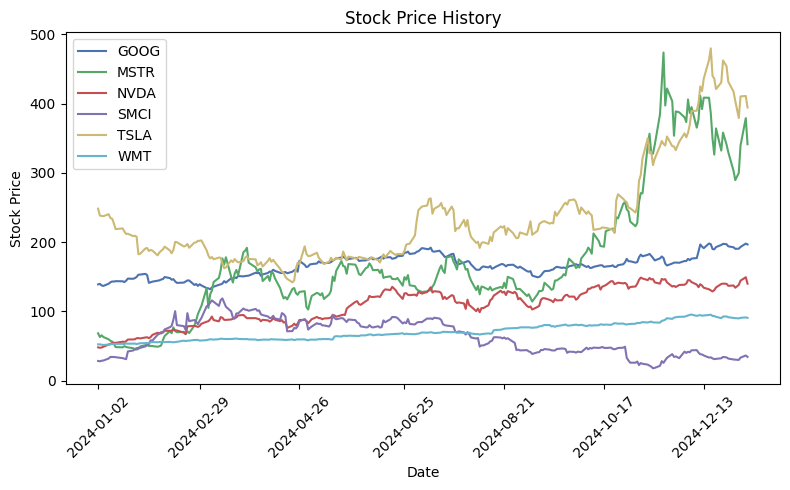

In [97]:
df = portfolio

# Plot
plt.figure(figsize=(8, 5))

# Plot each column
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

# Formatting the x-axis
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price History")
plt.legend()

tick_indices = df.index[::40]  # Select every 60th index
plt.xticks(tick_indices, [date.strftime('%Y-%m-%d')
           for date in tick_indices], rotation=45)

plt.tight_layout()

# Save the plot
plt.savefig('figures/stock_price_history.png', dpi=500, bbox_inches='tight')

# Show the plot
plt.show()

Expected annual return: 162.4%
Annual volatility: 45.9%
Sharpe Ratio: 3.50


GOOG    0.381518
MSTR    2.743167
NVDA    1.163911
SMCI    3.077039
TSLA    1.148767
WMT     0.143193
Name: mkt, dtype: float64

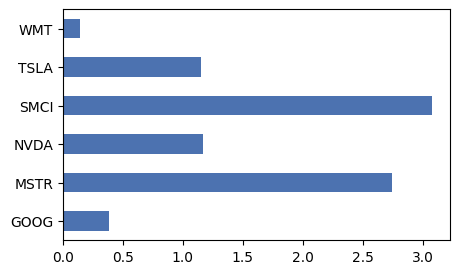

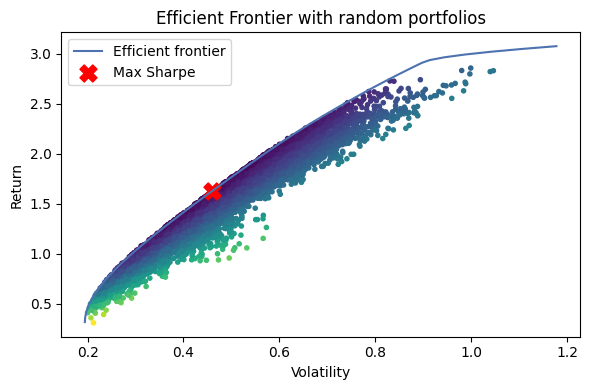

In [98]:
sample_cov = risk_models.sample_cov(portfolio, frequency=252)

S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
mu = expected_returns.capm_return(portfolio)

mu.plot.barh(figsize=(5, 3))

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)


latest_prices = get_latest_prices(portfolio)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

# Number of shares of each stock to purchase
allocation, leftover = da.greedy_portfolio()

n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(6, 4))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Max Sharpe')

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()

mu

#### Generate initial stock info

In [99]:
with open("assets/init_news_reports.json", "r") as f:
    stock_reports = json.load(f)
stock_reports

{'NVDA': "NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.",
 'GOOG': "Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mountain View, California. The company's primary revenue 

In [100]:
# brief stock introductions obtained from Perplexity.ai
def generate_data_summary(reports):
    summary = f"Recent reports indicate:\n"
    for ticker in tickers:
        report = reports[ticker]
        summary += f"For {ticker}:\n{report}\n\n"
    return summary

initial_stock_info = generate_data_summary(stock_reports)

#### Main class to integrate the LLM with the Portfolio Optimization model

In [113]:
class CoordinationFramework():
    def __init__(self, mu, Q, target_return, penalty=1, iteration=2, verbose=False):
        """
        Initialization of the class for coordination framework
        :param np.array mu: expected return of the stocks
        :param np.array Q: covariance matrix of the stocks
        :param float target_return: target return of the portfolio
        :param float penalty: penalty term in coordination algorithm
        :param float iteration: number of iteration of coordination algorithm
        """
        # Store the init params so we can restore them later
        self._init_mu = mu
        self._init_Q = Q
        self._init_target_return = target_return
        self._init_penalty = penalty
        self._init_iteration = iteration
        self._init_verbose = verbose

        # Now do the usual initialization
        self.mu = mu  # expected return
        self.Q = Q.to_numpy()  # covariance matrix
        self.n = len(mu)  # number of stocks
        self.target_return = target_return

        self.penalty = penalty
        self.iteration = iteration
        self.verbose = verbose

        # initialization
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    def reset_variables(self):
        """
        Reset all variables to their initial values, exactly as they were in __init__.
        """
        # Restore parameters
        self.mu = self._init_mu
        self.Q = self._init_Q.to_numpy()  
        self.n = len(self._init_mu)
        self.target_return = self._init_target_return

        self.penalty = self._init_penalty
        self.iteration = self._init_iteration
        self.verbose = self._init_verbose

        # Reinitialize mutable state variables
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    # In this function, the optimization model will update their preferred portfolio weights.
    def PortfolioOptimization_Agent(self, current_plan, verbose=False):
        # previous opt
        self.model = Model("mean_variance_optimization")
        self.model.setParam('OutputFlag', 0)
        # Add variables
        x = {}
        for i in range(self.n):
            x[i] = self.model.addVar(
                vtype=GRB.CONTINUOUS, name="x_{}".format(i))

        # Set objective
        obj = quicksum(self.Q[i, j] * x[i] * x[j]
                       for i in range(self.n) for j in range(self.n))
        dual = quicksum(
            self.optimization_price[i] * x[i] for i in range(self.n))
        penalty = self.penalty * \
            quicksum((x[i] - current_plan[i]) * (x[i] - current_plan[i])
                     for i in range(self.n))
        self.model.setObjective(obj + dual + penalty, GRB.MINIMIZE)

        # Add constraints
        self.model.addConstr(quicksum(x[i] for i in range(
            self.n)) == 1, "budget")  # budget constraint
        self.model.addConstr(quicksum(self.mu[i] * x[i] for i in range(
            self.n)) >= self.target_return, "target_return")  # target return constraint
        self.model.optimize()

        if verbose:
            print("\n[DEBUG] Building model with:")
            print(f"[DEBUG]   mu: {self.mu}")
            print(f"[DEBUG]   Q: {self.Q}")
            print(f"[DEBUG]   target_return: {self.target_return}")
            print("[DEBUG]   current_plan:", current_plan)
            print("[DEBUG]   optimization_price:", self.optimization_price)
            print("[DEBUG]   penalty:", self.penalty)
            print("[DEBUG]   x:", x)
            print("[DEBUG]   n:", self.n)
            
            self.model.write("debug/debug_model.lp")

            status = self.model.status
            print(f"[DEBUG] Gurobi optimization status: {status}")


        # Get results for portfolio weight on first stock
        weights = [x[i].x for i in range(self.n)]

        return weights

    def response_format(self):
        prompt = "please write your final recommendation in a single line, in the format below:\n\n"

        # Construct the label format dynamically based on the number of tickers.
        # Example of final output:  "AAPL: X1, MSFT: X2, AMZN: X3. Replace X1, X2, X3..."
        prompt += ", ".join([f"{ticker}: X{i+1}" for i, ticker in enumerate(tickers)])
        prompt += (
            ".\n\nReplace "
        )

        # Remind the model to replace placeholders with the actual confidence levels.
        prompt += ", ".join([f"X{i+1}" for i in range(len(tickers))])
        prompt += (
            " with the confidence level for each stock."
        )

        return prompt

    # In this function, the language model take the prompt as input and generate the preferred portfolio weights.
    def LLM_Agent(self, month_data, consensus_plan, month, iter, verbose=False):
        messages = [
            {"role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)

        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------
        current_prompt = ""

        if iter == 0:
            # Optionally include any initial stock info if this is the very first iteration.
            current_prompt += (
                f"{initial_stock_info}\n\n"
            )

        # if month != 0 and len(self.conversation_summaries) != 0:
        #     current_prompt += "Here is what happened in the last few months for you to gain a background understanding of what happened:\n"
        #     current_prompt += "\n".join(self.conversation_summaries)
        #     current_prompt += "\n\n"

        stock_prices = f"The stock prices today are:\n"
        for i, ticker in enumerate(tickers):
            ticker_close = month_data[ticker]['price']
            stock_prices += f"{ticker} = {ticker_close}"
            if i != len(tickers) - 1:
                stock_prices += ", "
        stock_prices += "\n"

        stock_news = ""
        for ticker in tickers:
            ticker_news = month_data[ticker]['news']
            stock_news += f"news for {ticker}:\n{ticker_news}\n\n"

        if iter == 0:
            # If this is the first iteration in a given month, include relevant news and price info.
            current_prompt += (
                "Please read the following information carefully.\n\n"
                f"---\n**Stock News**\n\n{stock_news}\n\n"
                f"---\n**Recent Stock Prices**\n\n{stock_prices}\n\n"
            )

        # Begin the main decision instructions.
        current_prompt += (
            "You are a trader responsible for making portfolio allocation decisions. "
            "Use all relevant information provided (such as any past decisions, news, or stock data) to "
            "decide how much to invest in each stock.\n\n"
            "Think about:\n"
            "1. Any news articles and how they might affect each stock.\n"
            "2. Any patterns in recent price movements.\n"
            "3. Previous decisions you have made regarding portfolio weights.\n"
        )

        # If we're past the first iteration, include guidance about consensus plans.
        if iter != 0 and self.optimization_plan != [0.0] * self.n:
            current_prompt += (
                "Also, here is the **current optimizer plan**:\n"
                f"{self.optimization_plan}\n\n"
                "Decide whether you agree with the optimizer's plan. If you do, make any necessary adjustments to "
                "move your portfolio allocation closer to it.\n\n"
            )

        # Ask the model for a recommendation. Emphasize the requirement to explain reasoning first, then provide the format.
        current_prompt += (
            "### Task\n"
            "1. **Explain your decision process**. Discuss your reasoning and any trade-offs you considered.\n"
            "2. **Provide a recommended investment decision** for each stock in terms of confidence, choosing from "
            "one of the following 7 levels:\n"
            "   - Very Low Confidence\n"
            "   - Low Confidence\n"
            "   - Somewhat Low Confidence\n"
            "   - Neutral\n"
            "   - Somewhat High Confidence\n"
            "   - High Confidence\n"
            "   - Very High Confidence\n\n"
            "Even if you are unsure, you **must** provide the best decision you can based on the available information.\n\n"
            "### Response Format\n"
            "After your explanation, " + self.response_format()
        )

        
        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------


        if verbose:
            print(f"\n# month {month} iter {iter} prompt: \n{current_prompt}\n")

        messages.append({"role": "user", "content": current_prompt})

        result_dict = []
        retry_messages = [m for m in messages]
        attempt = 0
        retry = True
        retry_reason = ""
        while retry:
            if attempt != 0:
                if retry_reason == "INVALID FORMAT":
                    new_message = "Sorry, I could not parse your response. Please try again with the correct specified formatting: " + self.response_format()
                elif retry_reason == "ZERO SUM":
                    new_message = "The sum of the weights for each stock cannot be 0. Please try again: " + self.response_format()
                else: # "MISSING TICKER"
                    new_message = "You must include a confidence level for each ticker. Pleas try again: " + self.response_format()

                retry_messages.append({
                    "role": "user", 
                    "content": new_message
                })
            attempt += 1
            # Make an API call to ChatGPT with the prompt
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=retry_messages
            )

            # Parse the decision from the response
            text = response.choices[0].message.content
            retry_messages.append({
                "role": "assistant",
                "content": text
            })

            if verbose:
                print(f"[DEBUG]\tChat reponse: {text}")

            CONFIDENCE_LEVELS = {
                "Very High": 0.6,
                "High": 0.5,
                "Somewhat High": 0.4,
                "Neutral": 0.3,
                "Somewhat Low": 0.2,
                "Low": 0.1,
                "Very Low": 0.0
            }

            # Create regex pattern from confidence levels
            pattern = "|".join(CONFIDENCE_LEVELS.keys())

            result_dict = {}
            for stock in tickers:
                # Use word boundary \b to ensure exact stock matches
                match = re.search(
                    fr'\b{stock}\b:\s*({pattern})',
                    text,
                    re.IGNORECASE
                )

                if match:
                    confidence = match.group(1).title()
                    result_dict[stock] = CONFIDENCE_LEVELS[confidence]
                else:
                    retry = True
                    if verbose:
                        print("[DEBUG]\tInvalid format, retrying.")
                        print(f"[DEBUG]\tfetched weights: {result_dict}")
                    continue

            retry = False

            if result_dict == {}:
                if verbose:
                    print("[DEBUG]\tInvalid format: could not find tickers, retrying.")
                retry = True
                retry_reason = "INVALID FORMAT"
                continue

            if sum(result_dict.values()) == 0:
                if verbose: 
                    print("[DEBUG]\tInvalid output: sum = 0")
                retry = True
                retry_reason = "ZERO SUM"
                continue

            if list(result_dict.keys()) != tickers:
                print(f"{list(result_dict.keys()) = }")
                if verbose: 
                    print("[DEBUG]\tInvalid output: not every ticker was outputted")
                retry = True
                retry_reason = "MISSING TICKER"
                continue

            if verbose:
                print(f"[DEBUG]\tfetched weights: {result_dict = }")
                retry = False
            

        # normalize sum to 1
        norm_factor = 1/sum(result_dict.values())
        result_dict = {k: v * norm_factor for k, v in result_dict.items()}
        result_dict = [r for r in result_dict.values()]


        self.conversation_history.append(
            {"role": "user", "content": current_prompt})
        self.conversation_history.append(
            {"role": "assistant", "content": text})

        norm_factor = 1/sum(result_dict)
        normalized_weights = [norm_factor * w for w in result_dict]

        return normalized_weights

    # update the consensus plan and activity price for the next iteration
    def update_plan(self, plan1, price1, plan2, price2):
        result = []
        # plan1 = [p for p in plan1.values()] # if using dict with tickers
        # plan2 = [p for p in plan2.values()]

        for p1, p2, pr1, pr2 in zip(plan1, plan2, price1, price2):
            average_plan = (p1 + p2) / 2
            average_price = (pr1 + pr2) / 2
            result.append(max(0, average_price / self.penalty + average_plan))
        return result

    def update_activity_price(self, current_activity_price, current_plan, new_plan):
        updated_prices = []

        for curr_price, curr_plan, new_plan_val in zip(current_activity_price, current_plan, new_plan):
            adjustment = self.penalty * (new_plan_val - curr_plan)
            updated_price = curr_price - adjustment
            updated_prices.append(updated_price)

        return updated_prices

    def test_convergence(self, all_llm_opt_plans):
        # if llm's plan and opt's plan do not differ by more than 5%
        try:
            plan_convergence = True
            for l in range(len(tickers)):
                if abs(all_llm_opt_plans[-1][l+len(tickers)+1] - all_llm_opt_plans[-1][l+2*len(tickers)+1]) > 1/20:
                    plan_convergence = False
                    break
            if plan_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")
        
        # if this iter's plan and last iter's plan do not differ by more than 1%
        # - weights have basically not changed in the past two iterations
        try:
            iter_convergence = True
            for i in range(1, len(all_llm_opt_plans[0])): 
                if abs(all_llm_opt_plans[-1][i] - all_llm_opt_plans[-2][i]) > 1/100:
                    iter_convergence = False
                    break
            if iter_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")

        return False
        
    def test_convergence_aux(self):
        max_diff = 0
        max_diff_ticker = None

        for l, ticker in enumerate(tickers):
            diff = self.plan_histories[-1][l+len(tickers)+1] - self.plan_histories[-1][l+2*len(tickers)+1]
            if diff > max_diff:
                max_diff = diff
                max_diff_ticker = self.plan_histories[-1][0]

        print(f"[DEBUG]\tThe max diff ticker is {max_diff_ticker} with a diff of {max_diff}")

        
        
    def OptAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            prices = yf.download(tickers, start=start_date, end=end_date)
            portfolio = prices["Adj Close"].dropna(how="all")
            portfolio.to_csv("assets/portfolio.csv", index=True)
            portfolio = pd.read_csv("assets/portfolio.csv", parse_dates=True, index_col="Date")
            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)

            self.current_plan = self.optimization_plan
            self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
            
            self.plan_histories.append(self.optimization_plan)

        return self.plan_histories
    
    def LLMAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, 0, verbose=verbose)
            
            self.current_plan = self.LLM_plan
            self.LLM_Price = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)
            
            self.plan_histories.append(self.LLM_plan)

        return self.plan_histories
    
    def summarize(self):
        messages = [
            {"role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)
        messages.append({
            "role": "user",
            "content": "Please summarize everything that happened in this conversation very succinctly, extracting the key pieces of information relevant to future stock assessments, as it will be used for another intelligent agent to overview what happened this month."
        })

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages
        )
        text = response.choices[0].message.content
        self.conversation_summaries.append(text)

    # In this function, the coordination algorithm will update the preferred portfolio weights of the two agents.
    def CoordinationAlgorithm(self, data, verbose=False):
        self.reset_variables()
        
        for month, month_data in enumerate(data):

            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            prices = yf.download(tickers, start=start_date, end=end_date)
            portfolio = prices["Adj Close"].dropna(how="all")
            portfolio.to_csv("assets/portfolio.csv", index=True)
            portfolio = pd.read_csv("assets/portfolio.csv", parse_dates=True, index_col="Date")
            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.summarize()

            self.conversation_history = []

            for i in range(self.iteration):
                # optimization agent get the preferred portfolio weights
                
                self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)
                # LLM agent get the preferred portfolio weights
                self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, i, verbose=verbose)

                # update the plan for the next iteration
                self.current_plan = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)

                # Coordinator update dual variable/prices
                self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
                self.LLM_price = self.update_activity_price(
                    self.LLM_price, self.LLM_plan, self.current_plan)

                self.penalty = 1 - i/self.iteration

                all_llm_opt = [f"month {month} iter {i}"] + self.current_plan + \
                    self.LLM_plan + self.optimization_plan

                self.plan_histories.append(all_llm_opt)

                columns = ['status']
                categories = ['all', 'llm', 'opt']
                for c in categories:
                    for ticker in tickers:
                        columns.append(f'{c} {ticker}')

                if self.test_convergence(self.plan_histories):

                    all_llm_opt = [f"CONVERGED month {month} iter {i}"] + self.current_plan + \
                        self.LLM_plan + self.optimization_plan
                    self.plan_histories[-1] = all_llm_opt
                    df = pd.DataFrame(self.plan_histories, columns=columns)
                    if verbose:
                        print("[DEBUG]\tConverged because {} < ")
                        print(df)
                    break

                else: 
                    # get the largest gap 
                    self.test_convergence_aux()

                df = pd.DataFrame(self.plan_histories, columns=columns)
                if verbose:
                    print("## updated weights\n```")
                    print(df)
                    print("\n```\n")

        return self.plan_histories

In [114]:
CoordFW = CoordinationFramework(
    mu, S, 1.42, penalty=1, iteration=20, verbose=False)

#### Run the optimizer only, as baseline

In [103]:
# opt_histories = CoordFW.OptAlgorithm(data_loaded)
# with open("assets/weights_opt.json", "w") as f:
#     json.dump(opt_histories, f, indent=4)

# -- OR --

with open("assets/weights_opt.json", "r") as f:
    opt_histories = json.load(f)

# opt_histories

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed


#### Run the LLM only, as baseline

In [ ]:
# llm_histories = CoordFW.LLMAlgorithm(data_loaded, False)
# with open("assets/weights_llm.json", "w") as f:
#     json.dump(llm_histories, f, indent=4)
    
# -- OR --

with open("assets/weights_llm.json", "r") as f:
    llm_histories = json.load(f)

# llm_histories

[[0.2727272727272727,
  0.22727272727272727,
  0.09090909090909091,
  0.13636363636363635,
  0.09090909090909091,
  0.18181818181818182],
 [0.23999999999999994, 0.16, 0.16, 0.08, 0.16, 0.19999999999999996],
 [0.26086956521739124,
  0.21739130434782605,
  0.17391304347826086,
  0.08695652173913043,
  0.08695652173913043,
  0.17391304347826086],
 [0.28571428571428575,
  0.23809523809523814,
  0.09523809523809526,
  0.04761904761904763,
  0.14285714285714288,
  0.19047619047619052],
 [0.2608695652173913,
  0.2173913043478261,
  0.1739130434782609,
  0.04347826086956522,
  0.13043478260869565,
  0.1739130434782609],
 [0.2727272727272727,
  0.22727272727272727,
  0.09090909090909091,
  0.045454545454545456,
  0.13636363636363635,
  0.22727272727272727],
 [0.18181818181818182,
  0.22727272727272727,
  0.13636363636363635,
  0.045454545454545456,
  0.18181818181818182,
  0.22727272727272727],
 [0.16666666666666669,
  0.20833333333333334,
  0.125,
  0.04166666666666667,
  0.20833333333333334,


#### Run the coordinator algorithm

In [115]:
coord_histories = CoordFW.CoordinationAlgorithm(data_loaded, True)
with open("assets/weights_coord.json", "w") as f:
    json.dump(coord_histories, f, indent=4)

# -- OR --

with open("assets/weights_coord.json", "r") as f:
    coord_histories = json.load(f)

weights_coord = [h[1:1+len(tickers)] for h in coord_histories]

weights_coord

[*********************100%***********************]  6 of 6 completed



# month 0 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  6 of 6 completed

[DEBUG]	Chat reponse: ### Decision Process

1. **Evaluating Current News Articles**:
   - **NVDA**: The significant increase in stock price, driven by robust demand in the GPU market, especially for AI applications, showcases a positive outlook. This justifies a strong investment in NVDA.
   - **GOOG**: With a solid endorsement by analysts and a slight increase in its stock price, GOOG maintains a stable position. However, recent layoffs may have some implications on operational efficiency; thus, it's recognized but with some caution.
   - **MSTR**: The drastic drop in share price and uncertainty regarding its Bitcoin strategy lead me to conclude it should remain virtually undetected in the portfolio.
   - **SMCI**: Ongoing concerns surrounding audit issues and possible delisting weigh heavily, though the company has potential in the AI space, so a cautious approach should be adopted.
   - **TSLA**: Recent volatility in stock price and disappointing delivery numbers suggest that while 


# month 1 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  6 of 6 completed

[DEBUG]	Chat reponse: ### Decision Process

1. **Analysis of Recent News and Performance**:
   - **NVDA (NVIDIA)**: Strong recent earnings demonstrated significant growth, especially in AI and cloud sectors, leading to a major stock surge of 27.4% in February. This momentum suggests that Nvidia is at the forefront of the tech industry, justifying a very high confidence level.
   
   - **GOOG (Alphabet)**: Recent controversies with its AI system sparked a decline in stock prices (down 4.4%), reflecting concerns about its reliability. Additionally, its average price decline of 2.7% over February indicates weakness. Hence, I decide on a somewhat low confidence level due to these challenges.
   
   - **MSTR (MicroStrategy)**: The company's strategic Bitcoin purchases generated a 15.9% rise in stock prices and bolster its relevance in the crypto space. This strong positive sentiment leads to a somewhat high confidence level.
   
   - **SMCI (Super Micro Computer)**: SMCI is still facing scr


# month 2 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  6 of 6 completed

[DEBUG]	Chat reponse: ### Decision Process

In evaluating the optimizer's proposed portfolio allocation, I considered current market conditions, recent news, and the historical performance of each stock. The optimizer suggests the following allocations:

- NVDA: 25.18%
- GOOG: 23.07%
- MSTR: 8.03%
- SMCI: 0.00%
- TSLA: 18.73%
- WMT: 24.99%

Here’s my analysis of each stock:

1. **NVIDIA (NVDA)**:
   - **News Impact**: Recent product launches and NVIDIA's strong presence in AI technology indicate continued growth potential.
   - **Price Movement**: Strong year-to-date performance with some fluctuations but remains robust overall.
   - **Confidence Level**: High Confidence. The innovation in AI keeps NVDA positioned well for long-term growth.

2. **Alphabet (GOOG)**:
   - **News Impact**: Continued expansion in cloud services and dominant revenue from advertising create a strong financial outlook.
   - **Price Movement**: Consistent upward trajectory suggests strong investor confidence.



# month 3 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  6 of 6 completed

[DEBUG]	Chat reponse: ### Decision Process Explanation

When evaluating the optimizer's current portfolio allocation plan, I closely considered the recent news updates, market sentiment, and individual stock performance. It's critical to balance potential growth against inherent risks to optimize investment outcomes. Here’s a breakdown by stock:

1. **NVIDIA (NVDA)**: NVIDIA's strong recent financial results, with substantial revenue and earnings growth driven by demand for semiconductors and AI technology, indicates a robust investment opportunity. The optimizer allocates approximately 32.00%, reflecting high confidence in future performance. I agree with this allocation and rate my confidence as **Very High Confidence**.

2. **Alphabet (GOOG)**: Alphabet continues to perform well, with significant revenue increases from both advertising and cloud segments. Given the recent trends and positive outlook, the optimizer's allocation of about 14.63% appears appropriate, reflecting confiden


# month 4 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  6 of 6 completed

[DEBUG]	Chat reponse: ### Decision Process Explanation

1. **Review of the Current Optimizer Plan**:
   - The optimizer suggests the following allocations:
     - NVDA: 45.48%
     - GOOG: 9.47%
     - MSTR: 0%
     - SMCI: 0%
     - TSLA: 32.66%
     - WMT: 12.40%
     
   - I will evaluate if these allocations align with my analysis of recent performance, news updates, and market trends.

2. **Analysis of Stocks**:
   - **NVIDIA (NVDA)**: The stock has exhibited extraordinary growth recently, with a significant performance boost (28.86% in May) due to its dominance in the GPU and AI sectors and an upcoming stock split. The allocation of 45.48% appears justified, and I would maintain or increase this allocation.
   
   - **Alphabet Inc. (GOOG)**: GOOG’s allocation of 9.47% feels quite conservative considering its previous reports of a 15% revenue increase and growth in the cloud computing sector. Its performance is steadily improving, and I would recommend raising this allocation.

  


# month 5 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  6 of 6 completed

[DEBUG]	Chat reponse: ### Decision Process Explanation

1. **Reviewing Current Optimizer Plan**:
   - The optimizer suggests allocations of approximately 28.87% for NVDA, 27.04% for GOOG, 6.21% for MSTR, 19.84% for SMCI, a negligible amount for TSLA (essentially 0%), and 18.04% for WMT.
   - This allocation strategy shows a preference for NVDA and GOOG, reflecting investor confidence in their significant growth prospects, especially in the AI and cloud segments.

2. **Analyzing News and Market Trends**:
   - **NVDA**: NVIDIA is maintaining strong momentum with its developments in AI and GPUs. The stock has shown resilience and positive price movements, further bolstered by demand for its products. The high allocation of 28.87% is justified due to its robust fundamentals and growth forecasts. I support this allocation and would consider keeping it as is or possibly increasing it slightly.
   - **GOOG**: Alphabet's diverse revenue streams, especially in cloud services and advertising, ha


# month 6 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  6 of 6 completed



# month 7 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  6 of 6 completed



# month 8 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[                       0%                       ]

[DEBUG]	Chat reponse: ### Decision Process Explanation

1. **News and Market Impact**:
   - **NVIDIA (NVDA)**: NVIDIA's stock has been under pressure after a strong earnings report that didn't meet high market expectations, compounded by delays in AI chip production and geopolitical tensions with China. These factors contribute to a riskier outlook for NVIDIA, so I assign **Somewhat Low Confidence** to NVDA.
   
   - **Alphabet Inc. (GOOG)**: Recent quarterly results show strong revenue growth, particularly driven by its Google Cloud services and AI initiatives. The company's strategic positioning and diverse product offerings contribute to its solid performance, leading me to assign **Very High Confidence**.

   - **MicroStrategy (MSTR)**: MicroStrategy is highly volatile, primarily due to its substantial investment in Bitcoin. While recent announcements of increased Bitcoin holdings may attract investor interest, the inherent risks associated with cryptocurrency volatility warrant a 

[*********************100%***********************]  6 of 6 completed



# month 9 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mounta

[*********************100%***********************]  6 of 6 completed



# month 10 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mount

[**********************67%*******                ]  4 of 6 completed

[DEBUG]	Chat reponse: ### Decision Process Explanation

In assessing the current optimizer's portfolio allocation, I will analyze the recent news and price movements affecting each stock, as well as consider previous portfolio decisions. This understanding will guide whether I agree with the optimizer's allocation or if adjustments are necessary.

1. **NVIDIA (NVDA)**:
   - **Current Allocation**: **35.61%**. NVIDIA has shown strong market performance with substantial revenue growth and a strong presence in AI technology. Its continued innovation and expansion make this a solid choice. Market sentiment remains positive, and the forecast looks favorable given the ongoing demand for GPUs. 
   - **Conclusion**: I agree with this allocation as it reflects strong potential.
   - **Confidence Level**: Very High Confidence

2. **Alphabet Inc. (GOOG)**:
   - **Current Allocation**: **32.57%**. Alphabet has demonstrated resilience with strong earnings and positive growth in its cloud and advert

[*********************100%***********************]  6 of 6 completed



# month 11 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For GOOG:
Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mount

[[0.24155278931257648,
  0.17549512258094807,
  0.08387283249764851,
  0.14599505758073122,
  0.13411489538367372,
  0.21896930264442177],
 [0.28843107834785997,
  0.18300429524808653,
  0.02614258236970165,
  0.14119790130010312,
  0.11201323106961165,
  0.24921091166463322],
 [0.3195149103424089,
  0.1928850828572967,
  7.626304264942781e-09,
  0.14495344008621977,
  0.07402111197211053,
  0.26862544711567404],
 [0.3141038535076344,
  0.1560251328185601,
  0.10962928575172311,
  0.09203764546370935,
  0.091874930449563,
  0.23632915200881288],
 [0.3118558266031677,
  0.1340372271077701,
  0.16574571360367887,
  0.06942771812944117,
  0.09956595827569648,
  0.21936755628024598],
 [0.31126953849070677,
  0.1211084941235605,
  0.19456290759617978,
  0.05915315954484148,
  0.10304113545052389,
  0.21086476479418742],
 [0.27656576462209886,
  0.17621264899329378,
  0.1471559183011146,
  0.026315924992232703,
  0.14661430777486692,
  0.22713543531638714],
 [0.2597098205019194,
  0.20677654

#### Display results

In [116]:
columns = ['status']
categories = ['all', 'llm', 'opt']
for c in categories:
    for ticker in tickers:
        columns.append(f'{c} {ticker}')

df = pd.DataFrame(coord_histories, columns=columns)
df

,status,all NVDA,all GOOG,all MSTR,all SMCI,all TSLA,all WMT,llm NVDA,llm GOOG,llm MSTR,llm SMCI,llm TSLA,llm WMT,opt NVDA,opt GOOG,opt MSTR,opt SMCI,opt TSLA,opt WMT
0,month 0 iter 0,0.241553,0.175495,8.387283e-02,1.459951e-01,1.341149e-01,0.218969,0.300000,0.200000,0.000000,0.150000,0.100000,0.250000,1.831056e-01,1.509902e-01,1.677457e-01,1.419901e-01,1.682298e-01,1.879386e-01
1,month 0 iter 1,0.288431,0.183004,2.614258e-02,1.411979e-01,1.120132e-01,0.249211,0.300000,0.200000,0.000000,0.150000,0.100000,0.250000,2.768622e-01,1.660086e-01,5.228516e-02,1.323958e-01,1.240265e-01,2.484218e-01
2,CONVERGED month 0 iter 2,0.319515,0.192885,7.626304e-09,1.449534e-01,7.402111e-02,0.268625,0.315789,0.210526,0.000000,0.157895,0.052632,0.263158,3.232403e-01,1.752438e-01,1.525261e-08,1.320121e-01,9.541064e-02,2.740930e-01
3,month 1 iter 0,0.314104,0.156025,1.096293e-01,9.203765e-02,9.187493e-02,0.236329,0.315789,0.105263,0.210526,0.052632,0.105263,0.210526,3.124182e-01,2.067871e-01,8.732256e-03,1.314437e-01,7.848670e-02,2.621320e-01
4,month 1 iter 1,0.311856,0.134037,1.657457e-01,6.942772e-02,9.956596e-02,0.219368,0.315789,0.105263,0.210526,0.052632,0.105263,0.210526,3.079222e-01,1.628113e-01,1.209651e-01,8.622386e-02,9.386876e-02,2.282088e-01
5,CONVERGED month 1 iter 2,0.311270,0.121108,1.945629e-01,5.915316e-02,1.030411e-01,0.210865,0.315789,0.105263,0.210526,0.052632,0.105263,0.210526,3.067496e-01,1.369538e-01,1.785995e-01,6.567474e-02,1.008191e-01,2.112032e-01
6,month 2 iter 0,0.276566,0.176213,1.471559e-01,2.631592e-02,1.466143e-01,0.227135,0.210526,0.263158,0.105263,0.052632,0.157895,0.210526,3.426052e-01,8.926740e-02,1.890487e-01,2.710371e-07,1.353339e-01,2.437446e-01
7,month 2 iter 1,0.259710,0.206777,1.305317e-01,1.688834e-08,1.670259e-01,0.235956,0.222222,0.277778,0.111111,0.000000,0.166667,0.222222,2.971974e-01,1.357753e-01,1.499522e-01,3.377669e-08,1.673851e-01,2.496900e-01
8,month 2 iter 2,0.246941,0.221382,1.219492e-01,5.162509e-08,1.733182e-01,0.236409,0.222222,0.277778,0.111111,0.000000,0.166667,0.222222,2.716607e-01,1.649856e-01,1.327873e-01,1.032502e-07,1.799698e-01,2.505965e-01
9,month 2 iter 3,0.246008,0.239566,9.250198e-02,7.441831e-11,1.800879e-01,0.241835,0.235294,0.294118,0.058824,0.000000,0.176471,0.235294,2.567224e-01,1.850151e-01,1.261804e-01,1.488366e-10,1.837052e-01,2.483768e-01


#### Graph the results

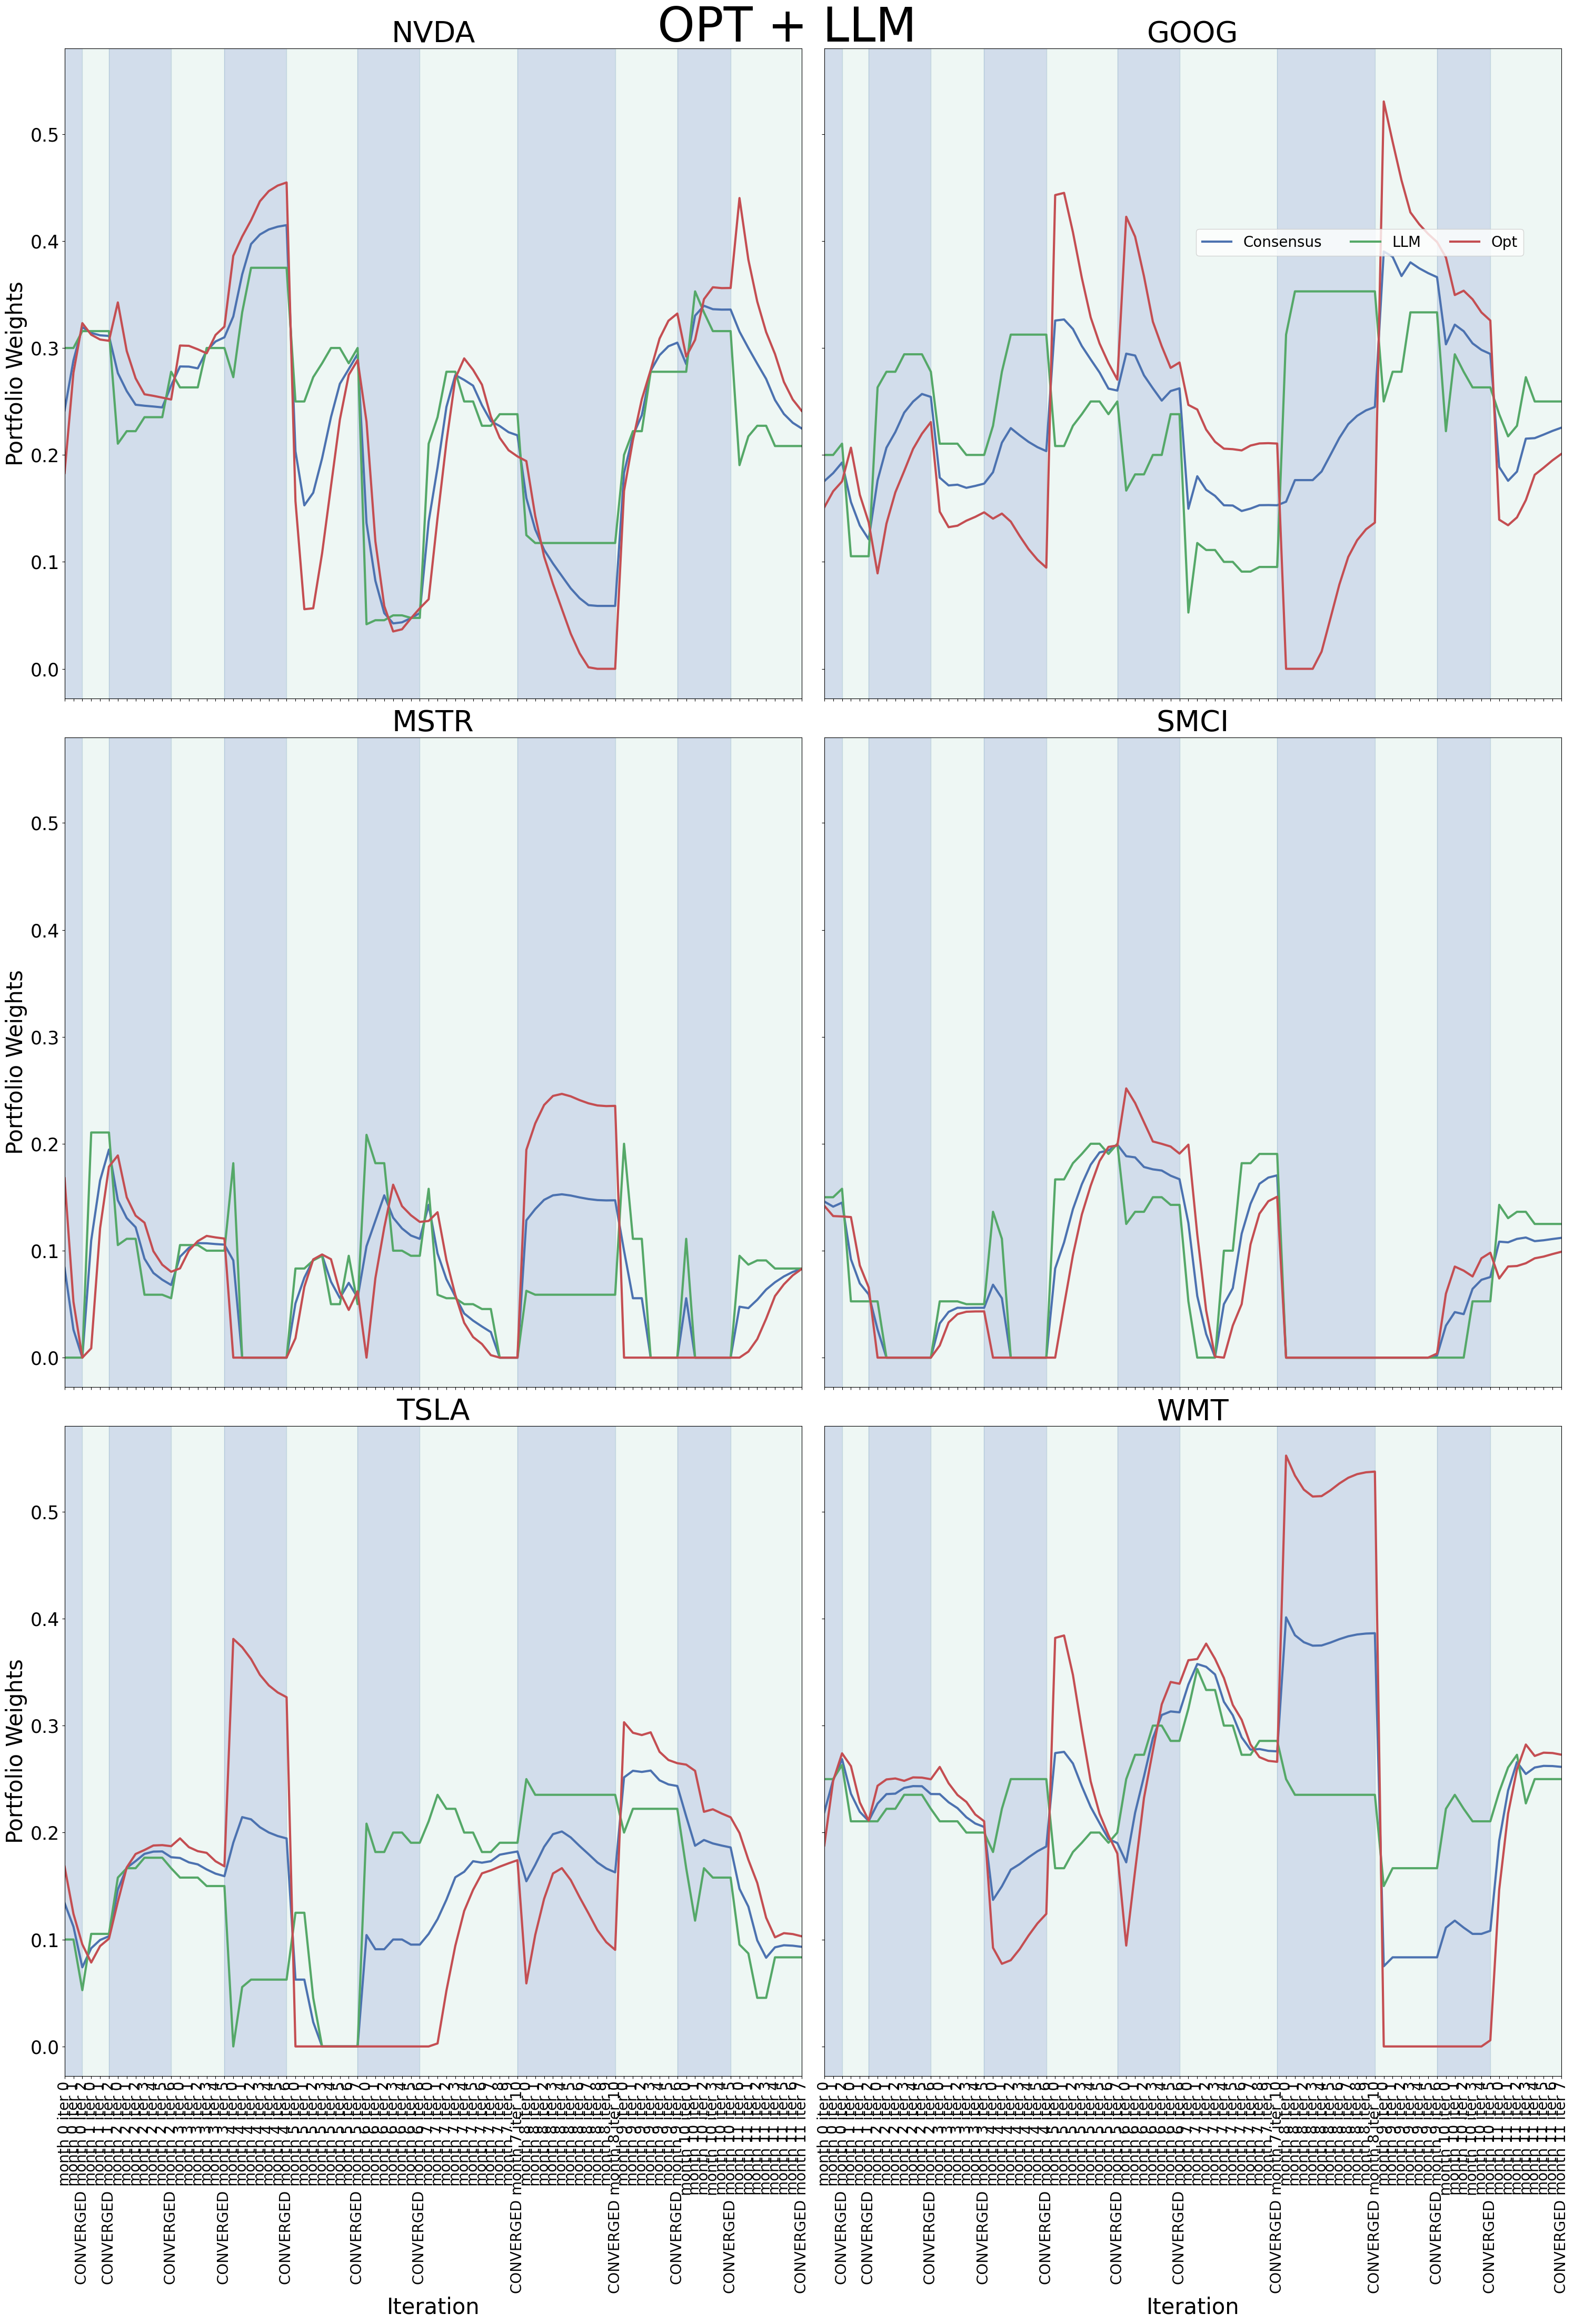

In [ ]:
rows = 3
columns = 2

fig, axes = plt.subplots(3, 2, figsize=(15*2, 15*3), sharey=True)  # 3x2 grid
fig.suptitle("OPT + LLM", fontsize=65)


# Flatten the 2D array of axes to make it easier to iterate
axes = axes.flatten()

# Define regions and colors
blue_region = (round(108/255, 2), round(143/255, 2), round(191/255, 2), 0.3)
green_region = (round(201/255, 2), round(230/255, 2), round(219/255, 2), 0.3)

days = []
prev = 0

for i, log in enumerate(df['status']):
    log = log.split()
    j = log.index("month")
    cur = log[j+1]
    if cur != prev:
        days.append(i-1)
        prev = cur

days.append(i+1)

regions = []
for i in range(len(days)-1):
    region_color = blue_region if i % 2 == 0 else green_region
    regions.append((days[i], days[i+1], region_color))

for i, ticker in enumerate(tickers):
    
    # Fill regions
    for start, end, color in regions:
        axes[i].axvspan(start, end, color=color, alpha=0.3)

    # Plot lines
    if i == 0:
        axes[i].plot(df['status'], df[f'all {ticker}'], label='Consensus', linewidth=3)
        axes[i].plot(df['status'], df[f'llm {ticker}'], label='LLM', linewidth=3)
        axes[i].plot(df['status'], df[f'opt {ticker}'], label='Opt', linewidth=3)
    else:
        axes[i].plot(df['status'], df[f'all {ticker}'], linewidth=3)
        axes[i].plot(df['status'], df[f'llm {ticker}'], linewidth=3)
        axes[i].plot(df['status'], df[f'opt {ticker}'], linewidth=3)
    
    # Title and tick parameters
    axes[i].set_title(f'{ticker}', fontsize=40)
    axes[i].tick_params(axis='x', rotation=90, labelsize=20)
    axes[i].tick_params(axis='y', labelsize=25)
    
    # X-axis limit
    axes[i].set_xlim(0, len(df['status']) - 1)
    
    # Y-label on first column
    if i in [i for i in range(0, rows*columns, columns)]:
        axes[i].set_ylabel("Portfolio Weights", fontsize=30)
    
    # X-label only on last row
    if i in [i for i in range(rows*columns-columns, rows*columns)]:
        axes[i].set_xlabel("Iteration", fontsize=30)
    else:
        # Hide x-tick labels for the first two rows
        axes[i].tick_params(axis='x', labelbottom=False)

# Add common legend (adjust location as you like)
fig.legend(loc=(0.76, 0.89), ncol=4, fontsize=20)
plt.tight_layout()

plt.savefig('assets/output.png', dpi=300)  # , bbox_inches='tight'
plt.show()


#### Backtesting
Seeing how the strategies perform based on historical data

In [127]:
def backtest(df, columns=None, weights_=None):
    i = 0

    initial_capital = 10000
    portfolio_value = initial_capital

    portfolio_history = [portfolio_value]

    while i < 11:
        if columns:
            weights = df.loc[i, columns].tolist()
        else:
            weights = weights_[i]

        # 2. -> buy jan 31
        shares = []
        initial_capital = portfolio_value

        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            shares_bought = initial_capital * weights[j] / ticker_price
            shares.append(shares_bought)
            portfolio_value -= shares_bought * ticker_price
            # print(f"{weights[j] = }\t{ticker_price = } -> {shares_bought = }")

        # 3. -> sell feb 31
        i += 1
        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            portfolio_value += shares[j] * ticker_price

        portfolio_history.append(portfolio_value)

    print(portfolio_value)
    return portfolio_history

df_end = df.iloc[[d - 1 for d in days[1:]]].reset_index(drop=True)
all_weights = ["all " + ticker for ticker in tickers]

# get the beginning price for each month
df_init = df[df['status'].str.contains('iter 0')].reset_index(drop=True)

portfolio_history_coordinated = backtest(df_end, columns=all_weights)
portfolio_history_opt = backtest(df_init, weights_=opt_histories)
portfolio_history_llm = backtest(df_init, weights_=llm_histories)

print(f"{portfolio_history_coordinated=}")
print(f"{portfolio_history_opt=}")
print(f"{portfolio_history_llm=}")


23820.874140902597
22940.62316630543
25954.771852744307
portfolio_history_coordinated=[10000, 13082.205873981748, 14992.456139270467, 13863.798744209558, 15726.716031627799, 16202.90459093021, 16211.333459813279, 14950.564739394322, 16288.110675667282, 18286.381232117583, 24078.043972320393, 23820.874140902597]
portfolio_history_opt=[10000, 13178.339438106354, 15147.50568054298, 14675.046153329164, 16237.337290367359, 17471.48047785711, 18049.54974626883, 17706.72527195575, 19849.817613064504, 20405.754879362365, 22796.512327100045, 22940.62316630543]
portfolio_history_llm=[10000, 13639.96711043141, 15678.512736802224, 14429.764756702294, 16704.27726643329, 17325.728960976718, 18004.57278727377, 17130.239428896108, 19134.92711307147, 20909.089178938775, 25960.248459160724, 25954.771852744307]


#### Plot the backtesting

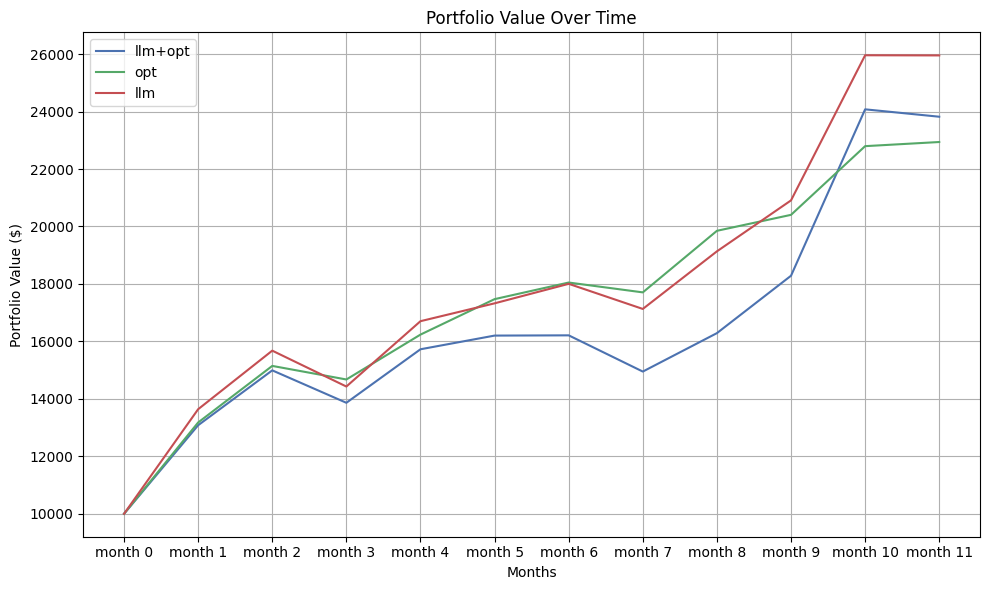

In [128]:
# Create labels for months 0 through 11
months = [f"month {i}" for i in range(12)]

plt.figure(figsize=(10, 6))

# Plot as a line chart (marker='o' to show points)
plt.plot(months, portfolio_history_coordinated, linestyle='-', label='llm+opt')
plt.plot(months, portfolio_history_opt, linestyle='-', label='opt')
plt.plot(months, portfolio_history_llm, linestyle='-', label='llm')

# Optional: If you prefer a bar chart instead of a line chart, use:
# plt.bar(months, portfolio_value_history, color='blue')

plt.title("Portfolio Value Over Time")
plt.xlabel("Months")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)

plt.legend()

plt.tight_layout()

plt.show()